# ML algorithms can still be effective, especially when dealing with smaller datasets or when interpretability is a priority

# Load Data

In [1]:
import os
import glob as gb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.utils import shuffle as shf

In [2]:
# Need a paper to choose suitable size
img_size = 64

- Load manually use libraries like OpenCV

In [3]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
# function to return the class of the images from its number, 'Normal' ~ 0, and 'PNEUMONIA' ~ 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

### Loading and saving images as .npy

In [4]:
# Loading and saving images as .npy
def load_to_np(dir):
    path = f'../dataset/chest_xray/{dir}/'

    X = []
    y = []
    for folder in  os.listdir(path) : 
        files = gb.glob(pathname= str(path + folder + '/*.jpeg'))
        for file in files: 

            image = cv2.imread(file)
            # resize images to img_size
            image_array = cv2.resize(image , (img_size,img_size))
            X.append(list(image_array))
            y.append(code[folder])

    np.save(f'X_{dir}', X)
    np.save(f'y_{dir}', y)

In [5]:
load_to_np('train')

In [6]:
load_to_np('test')

### Loading the .npy files as numpy arrays

In [7]:
# X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [8]:
# loaded_X_train[0][0]

In [9]:
# the shape return dimensions of X_train, we have 5216 images
print(loaded_X_train.shape)

(5216, 64, 64, 3)


In [10]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


In [11]:
# y_train and y_test contain the labels of each image, whether 0 'NORMAL' or 1 'PNEUMONIA'
print(loaded_y_train.shape)
print(loaded_y_test.shape)

(5216,)
(624,)


### Investigate pixel value distribution

In [12]:
# function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))

    # print image
    plt.subplot(1,2,1)
    plt.imshow(a)

    # plot pixel value distribution beside
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

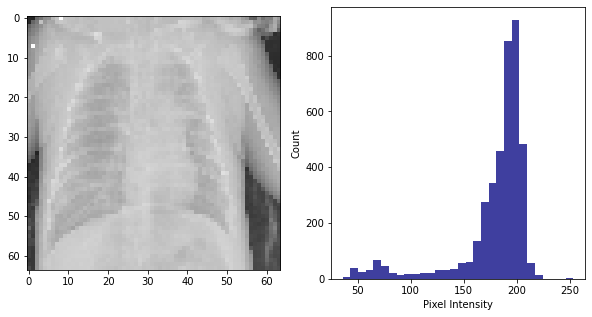

In [13]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

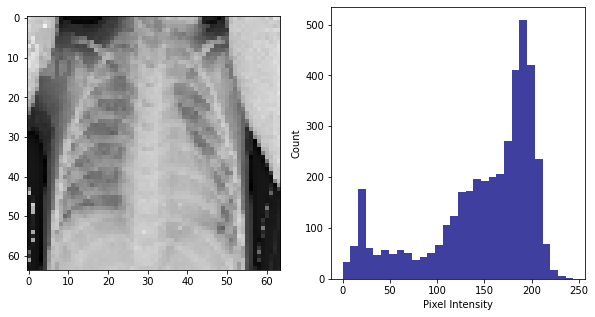

In [14]:
plotHistogram(loaded_X_test[np.random.randint(len(loaded_X_test))])

### Flatten and shuffle train and test sets

In [15]:
# flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((img_size,img_size,3))])
X_test = loaded_X_test.reshape([-1, np.product((img_size,img_size,3))])

In [16]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [17]:
y_train = loaded_y_train
y_test = loaded_y_test

In [18]:
# # shuffle train and test data sets in a consistent way
# X_train, y_train = shf(X_train, y_train, random_state=15)
# X_test, y_test = shf(X_test, y_test, random_state=15)

# Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

###  Oversampling using SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

# applying SMOTE to X_train and y_train to generate new samples to overcome the imbalance
from collections import Counter
smote = SMOTE(random_state = 11)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [21]:
print('Before SMOTE : ',Counter(y_train))
print('After SMOTE : ',Counter(y_train_res))

Before SMOTE :  Counter({1: 3875, 0: 1341})
After SMOTE :  Counter({0: 3875, 1: 3875})


In [22]:
# printing X_train and y_train shape after SMOTE
print(X_train_res.shape)
print(y_train_res.shape)

(7750, 12288)
(7750,)


# Evaluate models 

In [23]:
from lazypredict.Supervised import LazyClassifier

# Create a LazyClassifier instance and fit the training data
clf = LazyClassifier(verbose=0,
                        ignore_warnings=True,
                        custom_metric=None,
                        predictions=True,
                        random_state=12,
                        classifiers='all')
LazyClassifier()
# model, predictions = clf.fit(X_train_res, x_test,y_train_res, y_test)
model, predictions = clf.fit(X_train, X_test,y_train, y_test)
model

100%|██████████| 29/29 [56:22<00:00, 116.64s/it]  


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.81,0.80,0.80,0.81,2.93
Perceptron,0.80,0.76,0.76,0.79,5.27
BernoulliNB,0.78,0.76,0.76,0.78,3.46
PassiveAggressiveClassifier,0.79,0.75,0.75,0.79,10.27
LinearSVC,0.79,0.74,0.74,0.78,233.91
LogisticRegression,0.79,0.74,0.74,0.78,8.43
SVC,0.80,0.74,0.74,0.78,432.02
ExtraTreesClassifier,0.79,0.72,0.72,0.76,13.77
GaussianNB,0.74,0.72,0.72,0.74,3.40
